In [2]:
from PIL import Image  
import os
import os.path as osp
from tqdm import tqdm


dataset_root = "/mnt/nfs/hangkongbei"

# images_dir = "/root/datasets/testset/JPEGImages"
# imagesets_dir = "/root/datasets/testset/ImageSets/Main"
# anns_dir = "/root/datasets/testset/Annotations"

images_dir = osp.join(dataset_root, "voc-style/JPEGImages")
imagesets_dir = osp.join(dataset_root, "voc-style/ImageSets/Main")
anns_dir = osp.join(dataset_root, "voc-style/Annotations")

split_dataset_root = osp.join(dataset_root, "voc-style/split_dataset_new2")

split_images_dir = osp.join(split_dataset_root, "split_images_new")
split_imagesets_dir = osp.join(split_dataset_root, "ImageSets/Main")
split_anns_dir = osp.join(split_dataset_root, "Annotations")

to_process_set_name = "val.txt"
out_set_name = "minival_split_new.txt"

if not osp.exists(split_images_dir):
    os.makedirs(split_images_dir)
if not osp.exists(split_imagesets_dir):
    os.makedirs(split_imagesets_dir)
if not osp.exists(split_anns_dir):
    os.makedirs(split_anns_dir)



to_process_set_path = osp.join(imagesets_dir, to_process_set_name)

output_set_path = osp.join(split_imagesets_dir, out_set_name)

with open(to_process_set_path, "r") as f:
    imageids = [line.strip() for line in f.readlines()]
    
imageids[:4]

    


['00000002', '00000028', '00000029', '00000038']

In [3]:
import xml.dom.minidom
from multiprocessing.dummy import Pool as ThreadPool
import threading

def change_xml(src_xml, box, out_xml, size_thresh=15):
    dom = xml.dom.minidom.parse(src_xml)
    root = dom.documentElement
    
    imgid = osp.basename(out_xml).split(".")[0]
    imagename = imgid+".jpg"
    w,h = box[2]-box[0], box[3]-box[1]
    
    x1,y1 = box[0], box[1]
    x2,y2 = box[2], box[3]
    
    #set filename
    file_name = root.getElementsByTagName('filename')
    file_name[0].text = imagename
    
    #set size
    size = root.getElementsByTagName('size')[0]
    size.getElementsByTagName('width')[0].firstChild.data=str(w)
    size.getElementsByTagName('height')[0].firstChild.data=str(h)
    
    #set objects
    objects = root.getElementsByTagName('object')
    count_in = 0
    
    for object in objects:
        bndbox = object.getElementsByTagName('bndbox')[0]
        xmin_node = bndbox.getElementsByTagName('xmin')[0].childNodes[0]
        ymin_node = bndbox.getElementsByTagName('ymin')[0].childNodes[0]
        xmax_node = bndbox.getElementsByTagName('xmax')[0].childNodes[0]
        ymax_node = bndbox.getElementsByTagName('ymax')[0].childNodes[0]
        
        xmin = xmin_node.data
        ymin = ymin_node.data
        xmax = xmax_node.data
        ymax = ymax_node.data
        
        #judge if this object in this window
        if int(float(xmin)) >= x1 and int(float(xmin)) < x2 \
            and int(float(ymin)) >= y1 and int(float(ymin)) < y2:
                is_on_edge = False
                if int(float(xmax)) > x2:
                    xmax = x2
                    is_on_edge = True
                if int(float(ymax)) > y2:
                    ymax = y2
                    is_on_edge = True
                    
                #remove small box on edge
                if is_on_edge and ((int(float(xmax))-int(float(xmin))) < size_thresh or \
                                   (int(float(ymax))-int(float(ymin))) < size_thresh):
                    root.removeChild(object)
                    continue
                    
                #add offset
                xmin_node.data = str(int(float(xmin) - x1))
                ymin_node.data = str(int(float(ymin) - y1))
                xmax_node.data = str(int(float(xmax) - x1))
                ymax_node.data = str(int(float(ymax) - y1))
        else:
             root.removeChild(object)
        
    with open(out_xml, "w") as f:
        dom.writexml(f)     
    

wind_size = 1080
overlap = 360
stride = wind_size-overlap
split_xml = False
save_image = False

outfile = open(output_set_path,"w")
ext = "jpeg"
lock = threading.Lock()
count=0
def process_single_image(imageid):
    img = Image.open(osp.join(images_dir, imageid+".jpg"))
    #print(imageid)
    xml_path = osp.join(anns_dir, imageid+".xml")
    w, h = img.size
    #print(w,h)
    for i in range(0, w-wind_size+1, stride):
        for j in range(0, h-wind_size+1, stride):
            box = [i, j, i+wind_size, j+wind_size]
            split_imageid = imageid + "_%d_%d"%(i,j)
            outfile.write(split_imageid+"\n")
            split_imagefile = osp.join(split_images_dir, split_imageid+".jpg")
            split_xmlfile = osp.join(split_anns_dir, split_imageid+".xml")
            #print(box)
            #output split image
            if save_image:
                img.crop(box).save(split_imagefile, ext)
            #change xml
            if split_xml:
                change_xml(xml_path, box, split_xmlfile)
    
    #right
    i = w-wind_size;
    for j in range(0, h-wind_size+1, stride):
        box = [i, j, i+wind_size, j+wind_size]
        split_imageid = imageid + "_%d_%d"%(i,j)
        outfile.write(split_imageid+"\n")
        split_imagefile = osp.join(split_images_dir, split_imageid+".jpg")
        split_xmlfile = osp.join(split_anns_dir, split_imageid+".xml")
        #print(box)
        #output split image
        if save_image:
            img.crop(box).save(split_imagefile, ext)
        #change xml
        if split_xml:
            change_xml(xml_path, box, split_xmlfile)
            
    #down
    j = h-wind_size;
    for i in range(0, w-wind_size+1, stride):
        box = [i, j, i+wind_size, j+wind_size]
        split_imageid = imageid + "_%d_%d"%(i,j)
        outfile.write(split_imageid+"\n")
        split_imagefile = osp.join(split_images_dir, split_imageid+".jpg")
        split_xmlfile = osp.join(split_anns_dir, split_imageid+".xml")
        #print(box)
        #output split image
        if save_image:
            img.crop(box).save(split_imagefile, ext)
        #change xml
        if split_xml:
            change_xml(xml_path, box, split_xmlfile)
            
    #rightdown
    i = w-wind_size;
    j = h-wind_size;
    box = [i, j, i+wind_size, j+wind_size]
    split_imageid = imageid + "_%d_%d"%(i,j)
    outfile.write(split_imageid+"\n")
    split_imagefile = osp.join(split_images_dir, split_imageid+".jpg")
    split_xmlfile = osp.join(split_anns_dir, split_imageid+".xml")
    #print(box)
    #output split image
    if save_image:
        img.crop(box).save(split_imagefile, ext)
    #change xml
    if split_xml:
        change_xml(xml_path, box, split_xmlfile)
    
    
    
    #lock.acquire()
    global count
    count+=1
    print("%d/%d"%(count,len(imageids)), end='\n', flush=False)
    
    #lock.release()

# for imageid in tqdm(imageids[:4]):
#     process_single_image(imageid)
    #break

    
pool = ThreadPool(8) 

results = pool.map(process_single_image, imageids[:4])

pool.close() 
pool.join()

outfile.close()
with open(output_set_path,"r") as f:
    lines = f.readlines()
print(lines[:5])


1/871
2/8713/871
4/871

['00000002_0_0\n', '00000002_720_0\n', '00000002_1440_0\n', '00000002_2160_0\n', '00000002_2760_0\n']


(1080, 1080, 3)
1080 1080
0


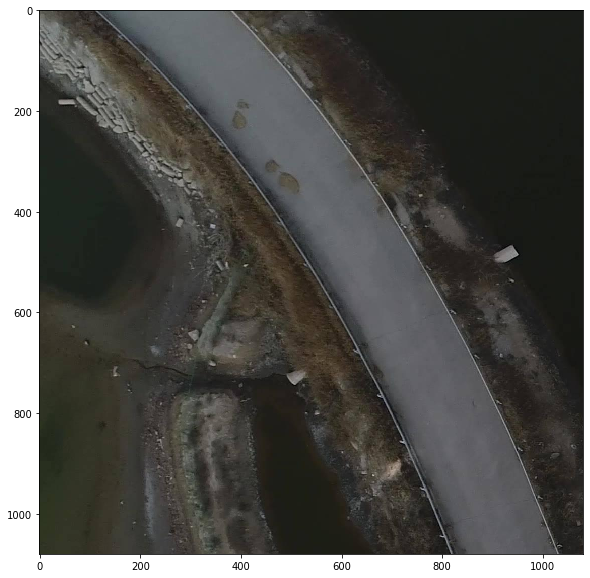

In [89]:
import xml.etree.ElementTree as ET
import cv2
from matplotlib import pyplot as plt
%matplotlib inline



def parse_rec(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(open(filename, encoding="utf-8"))
    ann={}
    width = tree.find("size").find("width").text
    height = tree.find("size").find("height").text
    ann["width"] = int(width)
    ann["height"] = int(height)
    print(width, height)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text if obj.find('name') is not None else "nknown"
        obj_struct['pose'] = obj.find('pose').text if obj.find('pose') is not None else "nknown"
        obj_struct['truncated'] = int(obj.find('truncated').text) if obj.find('truncated') is not None else 0
        obj_struct['difficult'] = int(obj.find('difficult').text) if obj.find('difficult') is not None else 0
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text)),
                              int(float(bbox.find('ymax').text))]
        objects.append(obj_struct)
    
    ann["objects"]=objects
    return ann

imageid = "00000028_0_0"

xml_file = osp.join(split_anns_dir, imageid+".xml")
img_file = osp.join(split_images_dir, imageid+".jpg")

img = cv2.imread(img_file)
print(img.shape)
ann = parse_rec(xml_file)
objs = ann["objects"]

offset = 0
print(len(objs))
for obj in objs:
    box = obj['bbox']
    #print(box)
    cv2.rectangle(img, (int(box[0])-offset, int(box[1])),(int(box[2]-offset),int(box[3])),(0,255,0),2)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#cv2.imwrite("test_sample.jpg", img)
